In [89]:
import pandas as pd
import numpy as np
import re

# NLP
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Prepocesamiento
from sklearn.preprocessing import MinMaxScaler

# Train, Test
from sklearn.model_selection import train_test_split

# Regresores
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Metricas para regresiones
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

# Visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#### Carga del dataset completo de comentarios

In [14]:
df_completo = pd.read_csv("Data/100178_Comentarios.csv", sep=";")

#### Extracción de la feature "texto" y el target "karma"

In [26]:
df = df_completo[["texto", "karma"]]
df.shape

(100178, 2)

#### Eliminación de valores nulos y conversión de tipo

In [27]:
print(f"Total de nulos por columna\n{df.isna().sum()}")
df = df.dropna()
df["karma"] = df["karma"].astype("int32")
df.reset_index(inplace=True, drop=True)
df.shape

Total de nulos por columna
texto     33
karma    785
dtype: int64


(99360, 2)

In [36]:
# df = df[(df["karma"] > 6) & (df["karma"] < 37)]
# df.reset_index(inplace=True, drop=True)
# df.shape

(68466, 2)

#### Definición de funciónes de limpieza de texto y de eliminación de hapaxes

In [46]:
# Cargar de las stopwords en español de nltk
stopwords = nltk.corpus.stopwords.words("spanish")

# Cargar del modelo de lenguaje para español de Spacy
nlp = spacy.load("es_core_news_sm")

# Función para la limpieza de comentarios
def limpieza_texto(texto):
    '''
    Función de limpieza de texto.\n
    Elimina números, signos de puntuación y caractereres no alfanuméricos.\n
    Elimina stopwords y lematiza la entrada.\n
    Necesita definición previa de la lista de "stopwords" y la inicialización del modelo de lenguaje en la variable "nlp"
    '''
    texto = re.sub(r'[^a-zA-Z0-9\sáéíóúñçÁÉÍÓÚäëïöüàèìòù]', ' ', texto)
    texto = re.sub(r'\d+', '', texto)

    comentario_nlp = nlp(texto)
    lemmas = [token.lemma_ for token in comentario_nlp]
    comentario_stopwords = ' '.join(lemmas)
    
    tokens_limpios = [palabra for palabra in comentario_stopwords.split(" ") if palabra.lower() not in stopwords and len(palabra) > 2]
    
    return ' '.join(tokens_limpios)

# Función para eliminar hapaxes
def eliminar_palabras(texto, lista):
    '''
    Elimina de un texto las palabras contenidas en una lista de palabras
    '''    
    texto_limpio = ' '.join([palabra for palabra in texto.split(" ") if palabra not in lista])
    return texto_limpio

def DistribucionPalabras_RiquezaLexica(datos):
    '''
    Función para mostrar la riqueza léxica de un texto.\n
    Retorna la distribución de palabras (nltk.FreqDist).
    
    '''
    # Tokenización del texto y generación de la distribución
    tokens = nltk.word_tokenize(text = datos, language = "spanish") 
    texto_nltk = nltk.Text(tokens = tokens)
    distribucion = nltk.FreqDist(samples = texto_nltk)

    # Obtención de la riqueza Léxica
    total_palabras = len(tokens)
    palabras_diferentes = len(set(tokens))
    riqueza_lexica = round((palabras_diferentes / total_palabras) * 100, 2)
    
    # Obtención de hapaxes
    hapaxes = distribucion.hapaxes()

    print(f"Total de palabras: {total_palabras}")
    print(f"Palabras diferentes: {palabras_diferentes}")
    print(f"Riqueza Lexica: {riqueza_lexica}% palabras distintas")
    print (f"Número total de hapaxes: {len(hapaxes)}")

    return distribucion

In [29]:
df["texto"] = df["texto"].apply(limpieza_texto)
df.head()

,texto,karma
0,dar hostia hartar ser despreciabl haber conseg...,77
1,ser ser opción seguro preferir muerto cerdo ll...,35
2,saludo Mysto hermoso,51
3,ser tal ser desproposito barbarie caber cosa d...,52
4,ser problema querer rebajar llegar punto pensa...,33


#### Se eliminan nuevamente los posibles nulos resultantes de la limpieza

In [74]:
df = df.dropna()
df.reset_index(inplace=True, drop=True)
df.shape

(98315, 2)

##### Exportacion Intermedia de Datos

In [ ]:
# df.to_csv("Data/100K_Comentarios_TrasLimpieza.csv", sep=";", encoding="utf-8",  index=False)
# with open("Data/Texto_Comentarios_100K.txt", mode="w", encoding="utf-8") as file:
#     for fila in df["texto"].values:
#         file.write(fila + " ")

Total de palabras: 1860683
Palabras diferentes: 93413
Riqueza Lexica: 5.02% palabras distintas
Número total de hapaxes: 49376


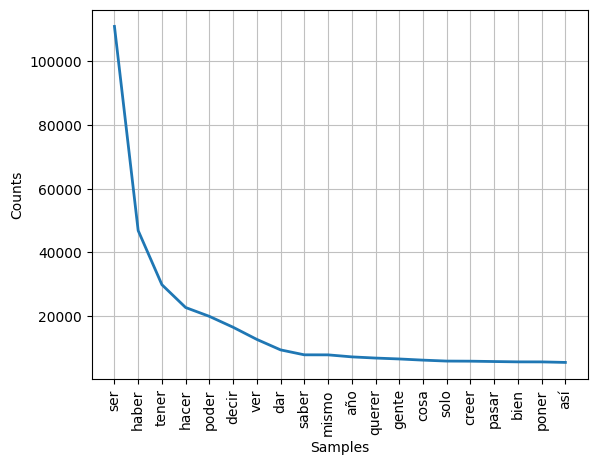

In [47]:
with open("Data/Texto_Comentarios_100K.txt", mode="r", encoding="utf-8") as file:
    texto_completo = file.read()

distribucion = DistribucionPalabras_RiquezaLexica(texto_completo)

#### Se obtiene la lista de hapaxes y se pasa a la función de eliminación

In [48]:
hapaxes = distribucion.hapaxes()
df["texto"] = df["texto"].apply(lambda x: eliminar_palabras(x, hapaxes))

#### Exportación intermedia de datos

In [108]:
# df.to_csv("Data/100KComentarios_Procesados.csv", sep=";", encoding="utf-8", index=False)
df = pd.read_csv("Data/100KComentarios_Procesados.csv", sep=";", encoding="utf-8")

# with open("Data/Texto_Comentarios_100K_Procesados.txt", mode="w", encoding="utf-8") as file:
#     for fila in df["texto"].values:
#         file.write(fila + " ")

with open("Data/Texto_Comentarios_100K_Procesados.txt", mode="r", encoding="utf-8") as file:
    texto_completo = file.read()

#### Distribución tras la eliminación de hapaxes

Total de palabras: 1811309
Palabras diferentes: 44039
Riqueza Lexica: 2.43% palabras distintas
Número total de hapaxes: 2


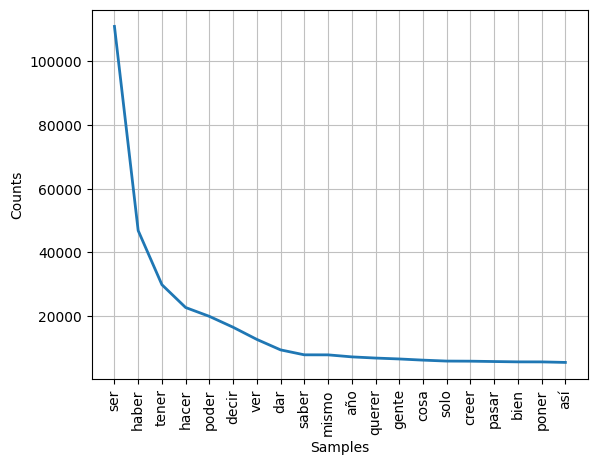

In [83]:
distribucion = DistribucionPalabras_RiquezaLexica(texto_completo)

In [123]:
df = df[(df["karma"] > -23) & (df["karma"] < 59)]

#### Distribución de la variable objetivo "karma"

In [124]:
px.histogram(df["karma"], marginal="box")

#### Conteo y Vectorizado de las palabras

In [125]:
# Inicializamos un objeto CountVecrtorizer()
count_vectorizer = CountVectorizer()

# Entrenamos el modelo y transformamos los datos.
bag = count_vectorizer.fit_transform(df["texto"])

bag

<87041x38488 sparse matrix of type '<class 'numpy.int64'>'
	with 1359922 stored elements in Compressed Sparse Row format>

#### Transformación de la matriz de palabras por frecuencias

In [126]:
# Inicializamos un objeto Tfidf
tfidf = TfidfTransformer()

# Entrenamos el Tfidf y transformamos la variable bag
bag_tfidf = tfidf.fit_transform(bag)
bag_tfidf

<87041x38488 sparse matrix of type '<class 'numpy.float64'>'
	with 1359922 stored elements in Compressed Sparse Row format>

#### Creación de los grupos de train/test

In [127]:
X_train, X_test, y_train, y_test = train_test_split(bag_tfidf, # X
                                                    df["karma"].values, # y
                                                    test_size = 0.3, random_state = 42)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape},  y_test: {y_test.shape}")

X_train: (60928, 38488), y_train: (60928,)
X_test: (26113, 38488),  y_test: (26113,)


#### Escalado del target para eliminar valores negativos y transformación logarítmica para acercarse a una distribución normal (gaussiana)

In [128]:
y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test = y_scaler.transform(y_test.reshape(-1,1))

In [129]:
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [130]:
modelos = [LinearRegression(),
            KNeighborsRegressor(),            
            DecisionTreeRegressor(),            
            AdaBoostRegressor(),
            GradientBoostingRegressor()]

In [133]:
# model = LinearRegression()
datos_modelos = list()

for model in modelos:
    print (f"#### Modelo: {str(model)} ####")
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)

    y_test_inv = np.exp(y_test) - 1
    yhat_inv = np.exp(yhat) - 1

    y_test_inv = y_scaler.inverse_transform(y_test_inv)
    yhat_inv = y_scaler.inverse_transform(yhat_inv.reshape(-1,1))

    #Metricas
    mae = mean_absolute_error(y_test_inv, yhat_inv)
    mse = mean_squared_error(y_test_inv, yhat_inv)
    rmse = root_mean_squared_error(y_test_inv, yhat_inv)
    r2 = r2_score(y_test_inv, yhat_inv)
    
    datos_modelos.append([str(model).strip("()"), model, mae, mse, rmse, r2])
    print(datos_modelos)

df_modelo = pd.DataFrame(data = datos_modelos, columns = ["name", "model", "mae", "mse", "rmse", "r2"])
df_modelo.sort_values("r2", ascending = False)

#### Modelo: LinearRegression() ####
[['LinearRegression', LinearRegression(), 17.35527958409468, 3524.3815902220676, 59.36650225692994, -22.48181281609597]]
#### Modelo: KNeighborsRegressor() ####
